# Fink and Gaia alerts

In this notebook, we inspect the crossmatch between Fink alerts and Gaia alerts. We first took all alerts issued by Gaia (http://gsaweb.ast.cam.ac.uk/alerts/alertsindex), and cross match with Fink. Of the 20,095 alerts, we found 7,464 match (37%). The resulting crossmatch result can be found in `gaia_xmatch.csv`.

In [13]:
import requests
import io

import pandas as pd
import numpy as np

from astropy.time import Time
from collections import Counter


import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('talk')

## Loading the data

In [2]:
gaia = pd.read_csv('gaia_xmatch.csv')

# select only columns of interest
cols = ['Name', 'i:objectId', 'Class', 'v:classification', 'Date', 'i:jdstarthist', 'Comment']
pdf = gaia[cols]

pdf['i:jdstarthist'] = pdf['i:jdstarthist'].apply(lambda x: Time(x, format='jd').iso)

/tmp/ipykernel_593727/474047863.py:1: DtypeWarning: Columns (123) have mixed types. Specify dtype option on import or set low_memory=False.
  gaia = pd.read_csv('gaia_xmatch.csv')
/tmp/ipykernel_593727/474047863.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['i:jdstarthist'] = pdf['i:jdstarthist'].apply(lambda x: Time(x, format='jd').iso)


The schema of the dataframe is the following:
- `Name`: Gaia name of the object
- `i:objectId`: ZTF name of the object
- `Class`: Gaia classification
- `v:classification`: Fink classification
- `Date`: first detection by Gaia
- `i:jdstarthist`: first detection by ZTF/Fink
- `Comment`: comment from the Gaia team


In [3]:
pdf.head(5)

,Name,i:objectId,Class,v:classification,Date,i:jdstarthist,Comment
0,Gaia22cbp,ZTF18abjrgwp,unknown,YSO,2022-04-14 22:25:06,2018-07-02 10:05:55.003,~2 mag dimming in candidate YSO
1,Gaia22cbo,ZTF18aauxgud,unknown,Seyfert_2,2022-05-10 19:52:14,2019-07-25 04:18:31.003,brightening at the centre of a known Seyfert 2...
2,Gaia22cbo,ZTF22aahhzng,unknown,Seyfert_2,2022-05-10 19:52:14,2019-07-25 04:18:31.003,brightening at the centre of a known Seyfert 2...
3,Gaia22cbm,ZTF18aaqpeoq,SN Ia,Unknown,2022-05-11 07:59:43,2021-03-08 06:23:11.999,confirmed SN Ia near the centre of galaxy WISE...
4,Gaia22cbj,ZTF22aahebcu,SN Ia,SN candidate,2022-05-10 13:51:14,2022-04-21 05:48:35.004,confirmed SN Ia


Here we show the top 20 classes from the Fink classification:

In [4]:
pdf.groupby('v:classification').count().sort_values('Name', ascending=False)[['Name']].head(20)

,Name
v:classification,
Unknown,3823
SN candidate,1207
QSO,685
CataclyV*,269
SN,204
Seyfert_1,161
Galaxy,122
BLLac,120
Star,114


Most Gaia alerts have no counterpart in Fink (`Unknown` class), follow by `SN candidate` and `QSO`. Let see what is the classification from Gaia for these alerts:

In [5]:
pdf.groupby('Class').count().sort_values('Name', ascending=False)[['Name']]

,Name
Class,
unknown,4217
SN Ia,940
QSO,803
CV,433
SN II,332
YSO,165
AGN,128
SN IIn,68
BL Lac,68


As for Fink, most Gaia alerts have no classification, follow by `SN Ia` and `QSO`. For each Gaia class, let see what Fink says:

In [6]:
gaia_classification = pdf\
    .groupby('Class')\
    .agg({'v:classification': list})['v:classification']\
    .apply(lambda x: Counter(x))

In [7]:
gaia_classification

Class
AGN               {'Seyfert_1': 66, 'Blazar': 2, 'Galaxy': 1, 'U...
BL Lac            {'BLLac': 56, 'Radio(cm)': 1, 'QSO': 3, 'Radio...
CV                {'Unknown': 152, 'SN candidate': 25, 'CataclyV...
LBV                                                  {'Unknown': 2}
Nova                   {'SN candidate': 3, 'Unknown': 4, 'Nova': 5}
Other                          {'Star': 1, 'Unknown': 1, 'LMXB': 1}
QSO               {'Seyfert_1': 65, 'QSO': 629, 'Unknown': 59, '...
RCrB                                              {'Erupt*RCrB': 2}
SLSN              {'Unknown': 12, 'SN candidate': 7, 'EmG': 1, '...
SN                {'SN candidate': 1, 'Unknown': 1, 'Candidate_S...
SN I              {'Unknown': 2, 'Candidate_SN*': 1, 'SN candida...
SN II             {'SN candidate': 102, 'Unknown': 162, 'EmG': 1...
SN IIP            {'SN candidate': 8, 'Unknown': 15, 'Candidate_...
SN IIb            {'Galaxy': 1, 'Unknown': 7, 'SN candidate': 6,...
SN IIn            {'SN candidate': 8, 'Unk

Specifically focusing on Gaia QSO, Fink counterparts are:

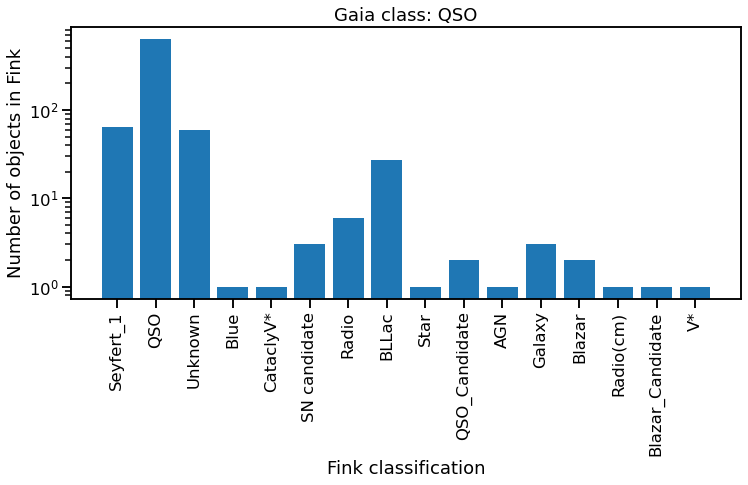

In [8]:
aclass = 'QSO'

fig = plt.figure(figsize=(12, 5))

plt.bar(
    gaia_classification[aclass].keys(), 
    gaia_classification[aclass].values()
)
plt.title('Gaia class: {}'.format(aclass))
plt.ylabel('Number of objects in Fink')
plt.xlabel('Fink classification')
plt.yscale('log')
plt.xticks(rotation=90);

## QSO

The top 3 classes are the same: `unknown`, `SN`, `QSO`.

In [9]:
f1 = pdf['Class'] == 'QSO'
f2 = pdf['v:classification'] == 'QSO'

n1 = len(pdf[f1])
n2 = len(pdf[f2])
n12 = len(pdf[f1 & f2])

msg = """
{} QSO found in Gaia
{} QSO found in Fink
{} QSO found both in Gaia & Fink
""".format(n1, n2, n12)

print(msg)


803 QSO found in Gaia
685 QSO found in Fink
629 QSO found both in Gaia & Fink



In [10]:
def plot_photometry(pdf, gaia_name, gaia_class):
    fig = plt.figure(figsize=(15, 6))

    colordic = {1: 'C0', 2: 'C1'}

    for filt in np.unique(pdf['i:fid']):
        maskFilt = pdf['i:fid'] == filt

        # The column `d:tag` is used to check data type
        maskValid = pdf['d:tag'] == 'valid'
        plt.errorbar(
            pdf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskValid & maskFilt]['i:magpsf'],
            pdf[maskValid & maskFilt]['i:sigmapsf'],
            ls = '', marker='o', color=colordic[filt]
        )

        maskUpper = pdf['d:tag'] == 'upperlim'
        plt.plot(
            pdf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskUpper & maskFilt]['i:diffmaglim'],
            ls='', marker='^', color=colordic[filt], markerfacecolor='none'
        )

        maskBadquality = pdf['d:tag'] == 'badquality'
        plt.errorbar(
            pdf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskBadquality & maskFilt]['i:magpsf'],
            pdf[maskBadquality & maskFilt]['i:sigmapsf'],
            ls='', marker='v', color=colordic[filt]
        )

    title = 'Fink: {} - {} | Gaia: {} - {}'.format(
        pdf['i:objectId'].values[0],
        pdf['v:classification'].values[0],
        gaia_name,
        gaia_class
    )
    
    print('https://fink-portal.org/{}'.format(pdf['i:objectId'].values[0]))
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Magnitude')
    plt.show()

Display the ZTF photometry for 10 first QSO found both in Fink & Gaia:

https://fink-portal.org/ZTF21acjfbvi


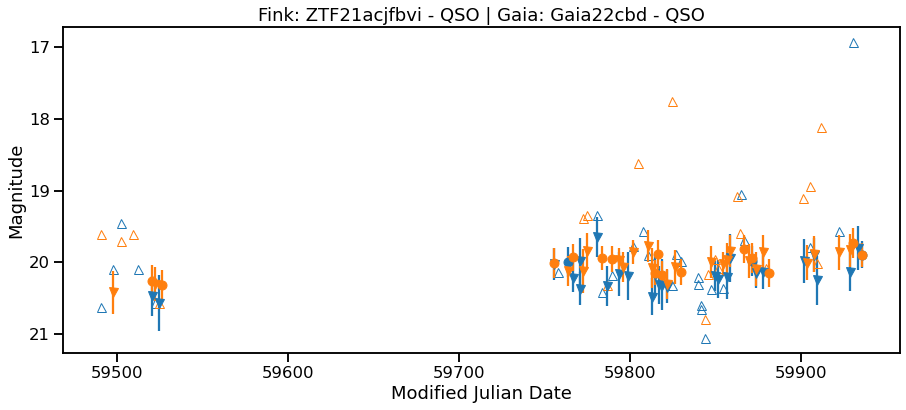

https://fink-portal.org/ZTF19accvnsd


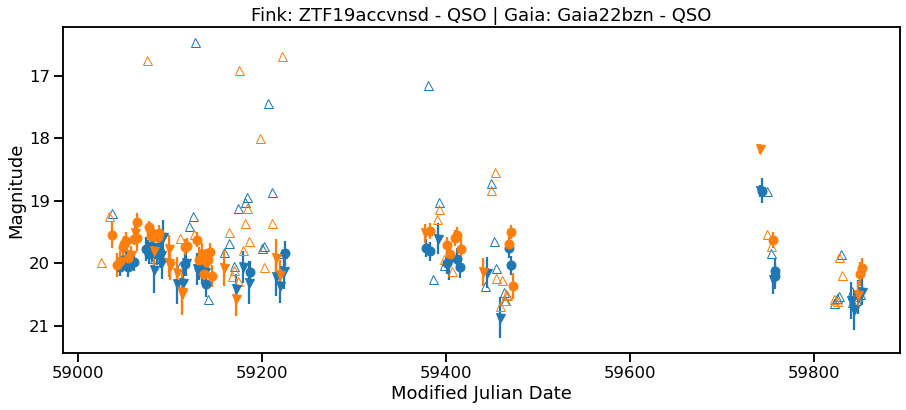

https://fink-portal.org/ZTF19acrnaky


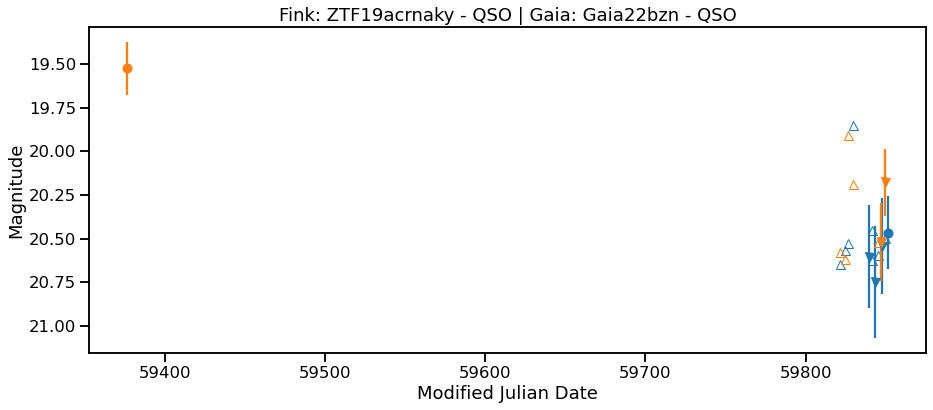

https://fink-portal.org/ZTF20acdcjgn


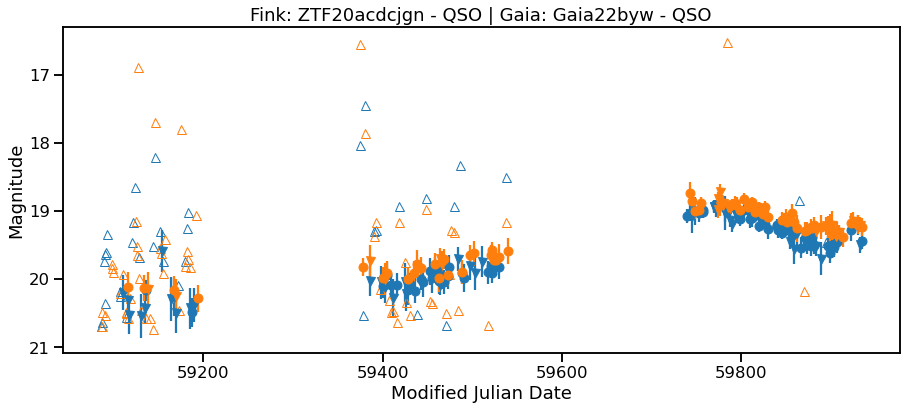

https://fink-portal.org/ZTF20abgvcnw


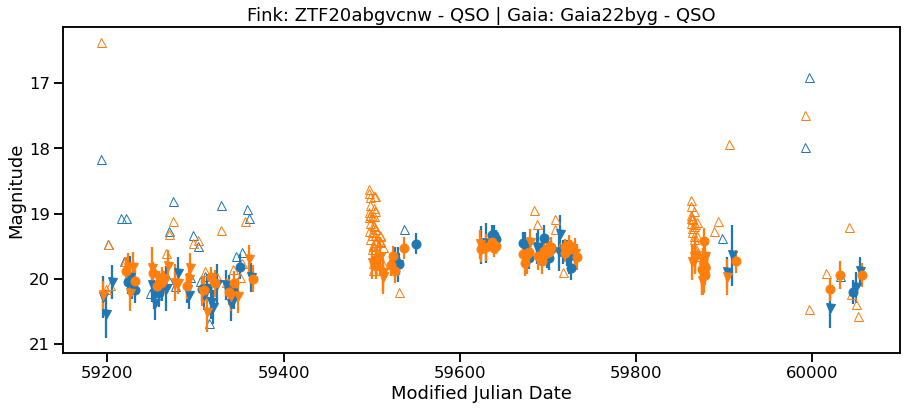

https://fink-portal.org/ZTF20aaosshr


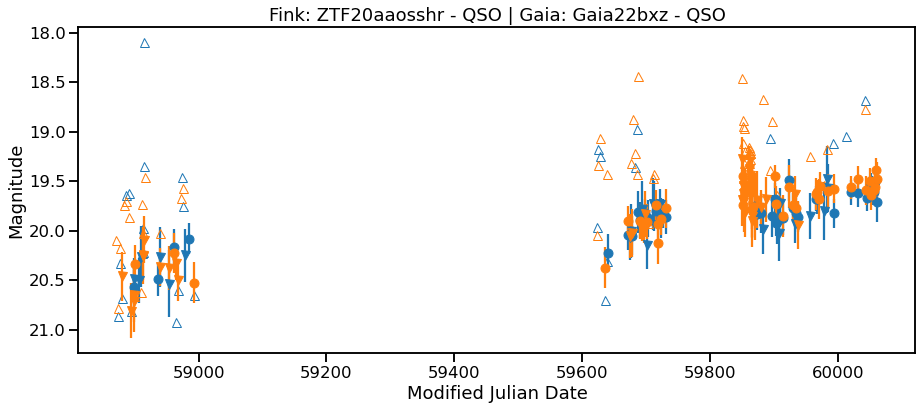

https://fink-portal.org/ZTF20aboctux


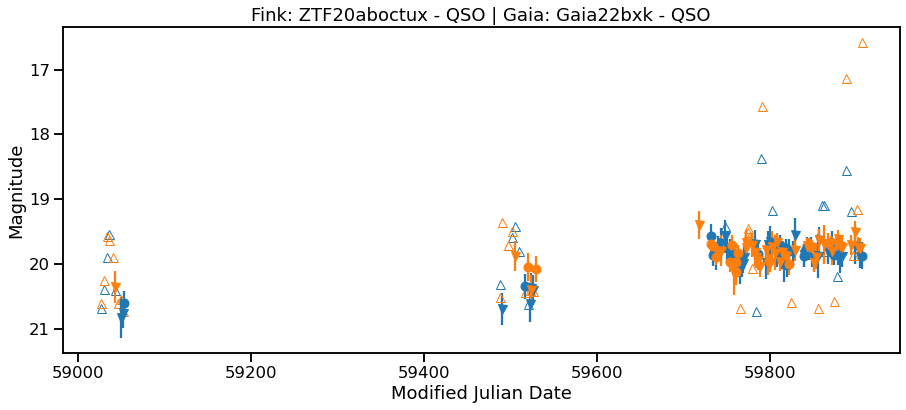

https://fink-portal.org/ZTF22aaeuofv


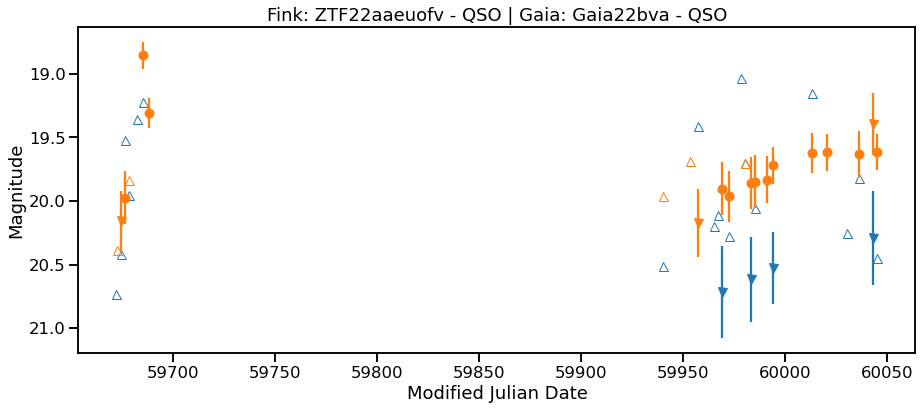

https://fink-portal.org/ZTF19aapaodl


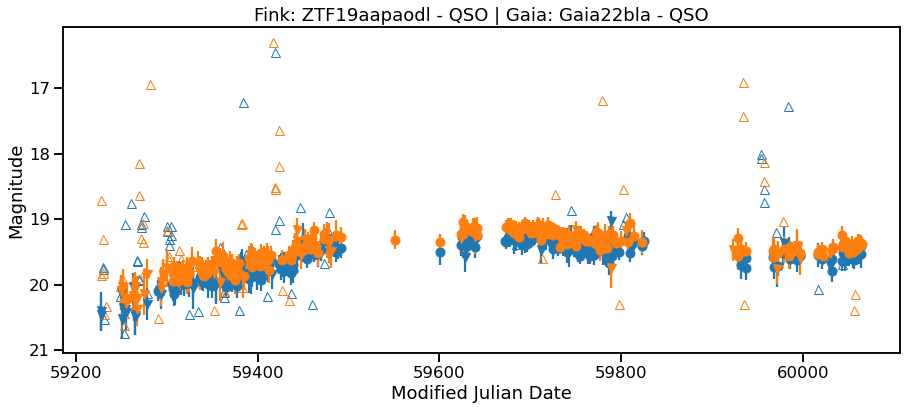

https://fink-portal.org/ZTF19aaruxui


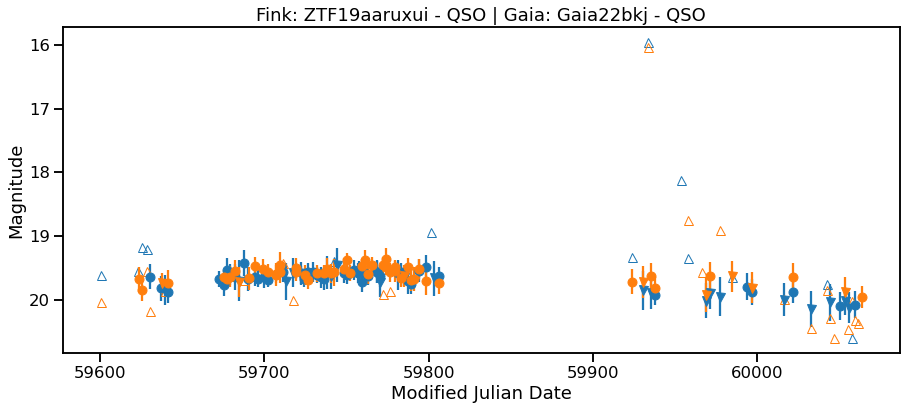

In [14]:
fink_oids = gaia[f1 & f2]['i:objectId'].values
gaia_names = gaia[f1 & f2]['Name'].values
gaia_classes = gaia[f1 & f2]['Class'].values

NOBJECT = 10
for index, oid in enumerate(fink_oids[0:NOBJECT]):
    r = requests.post(
      'https://fink-portal.org/api/v1/objects',
      json={
        'objectId': oid,
        'withupperlim': 'True'
      }
    )

    # Format output in a DataFrame
    phot = pd.read_json(io.BytesIO(r.content))
    plot_photometry(phot, gaia_names[index], gaia_classes[index])

Display the ZTF photometry for 10 first QSO found in Fink but not in Gaia:

https://fink-portal.org/ZTF21aaftgmg


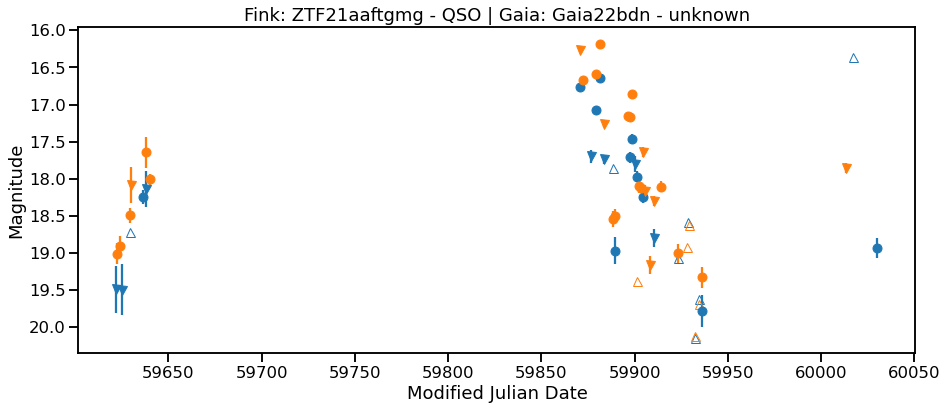

https://fink-portal.org/ZTF20abmtxog


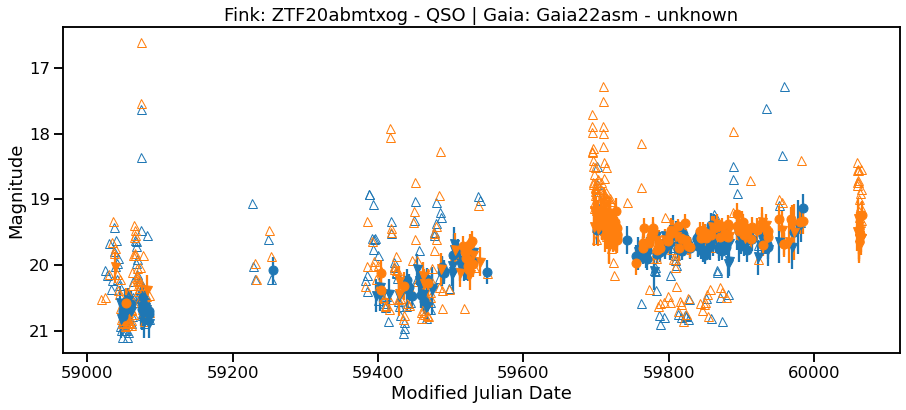

https://fink-portal.org/ZTF18aczenfp


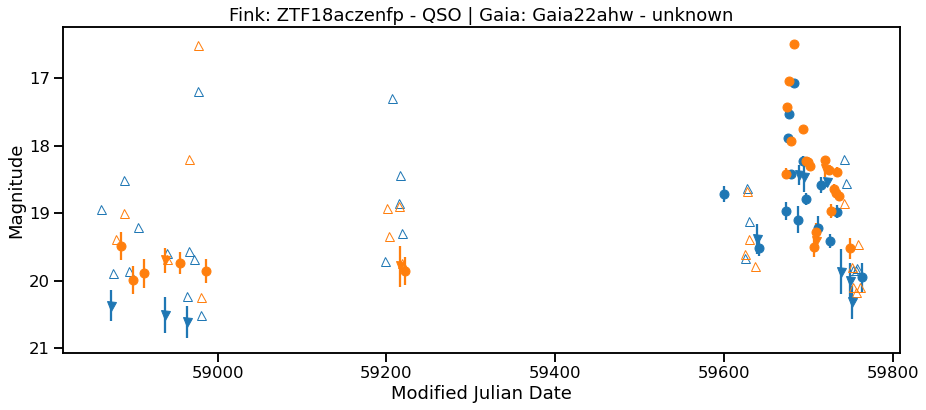

https://fink-portal.org/ZTF21abdglhq


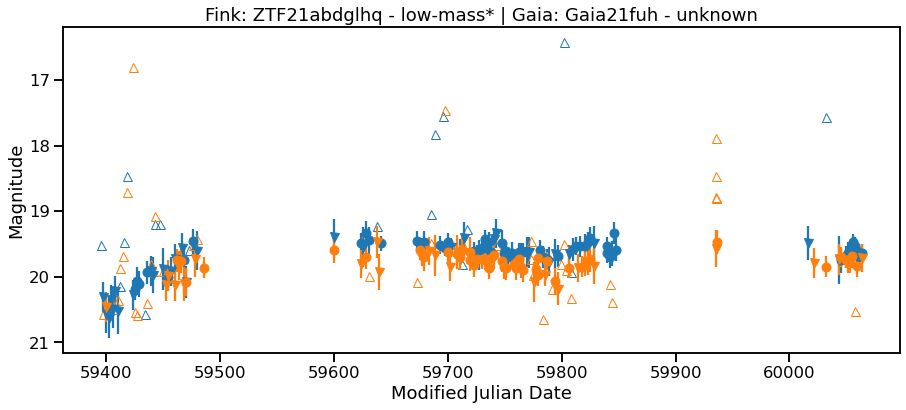

https://fink-portal.org/ZTF21aamqfiz


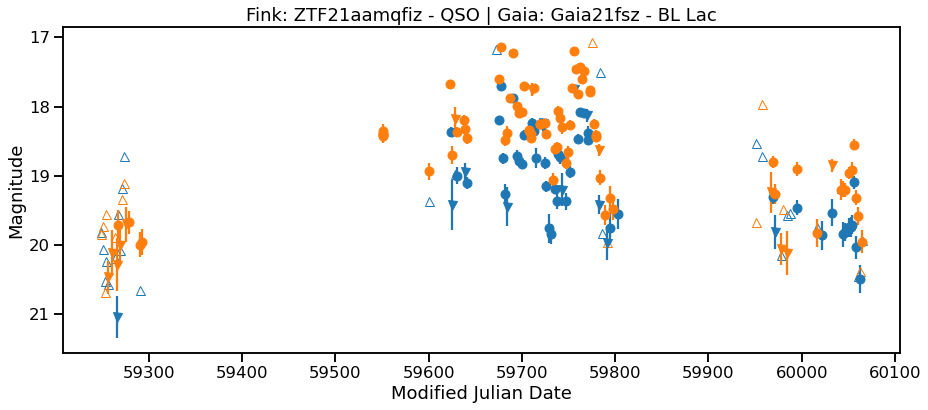

https://fink-portal.org/ZTF18aadigse


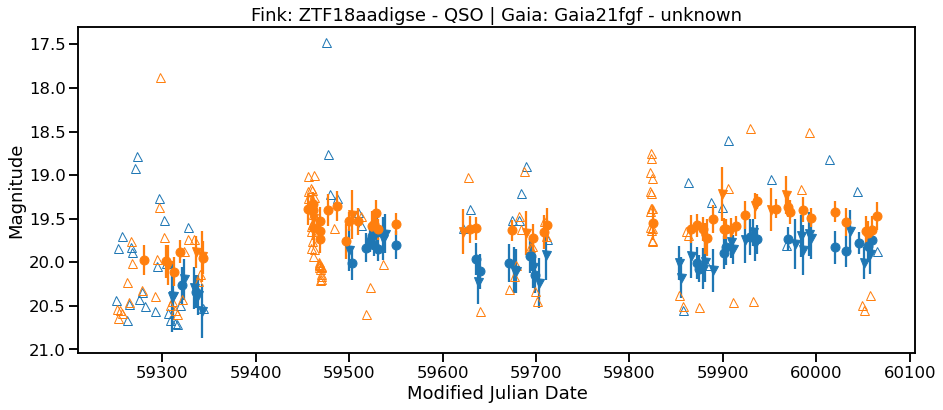

https://fink-portal.org/ZTF18abakyvt


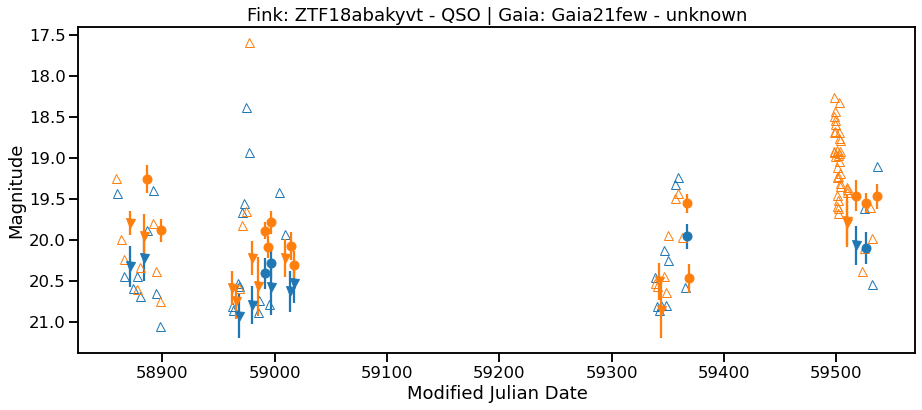

https://fink-portal.org/ZTF22aaevdle


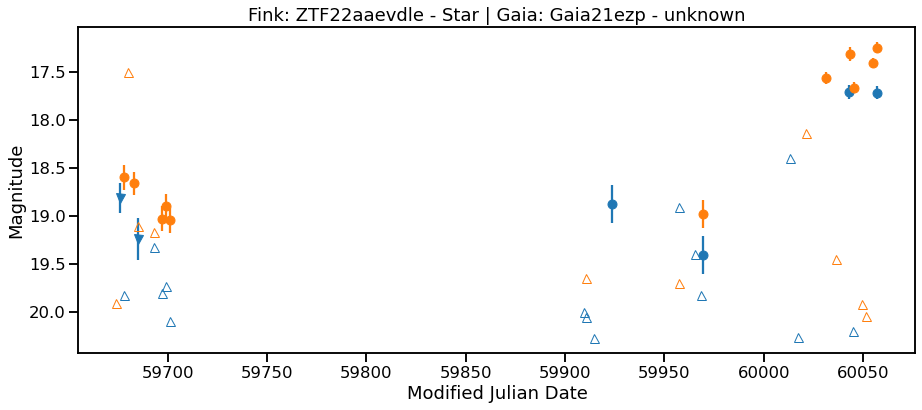

https://fink-portal.org/ZTF21aaifxon


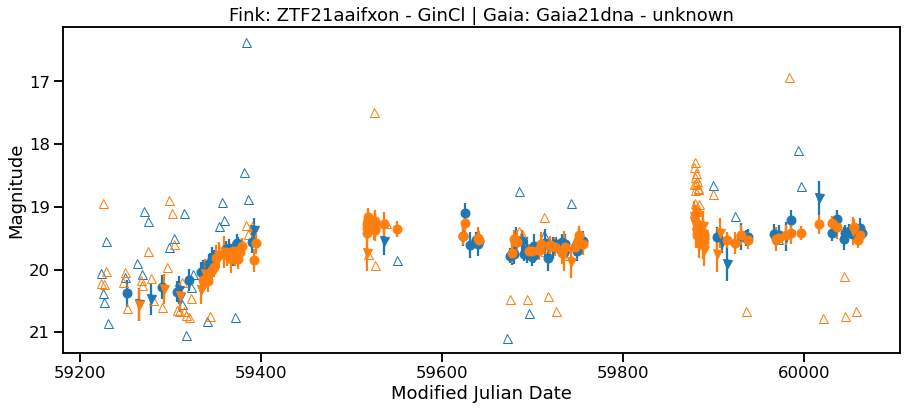

https://fink-portal.org/ZTF19aacprpf


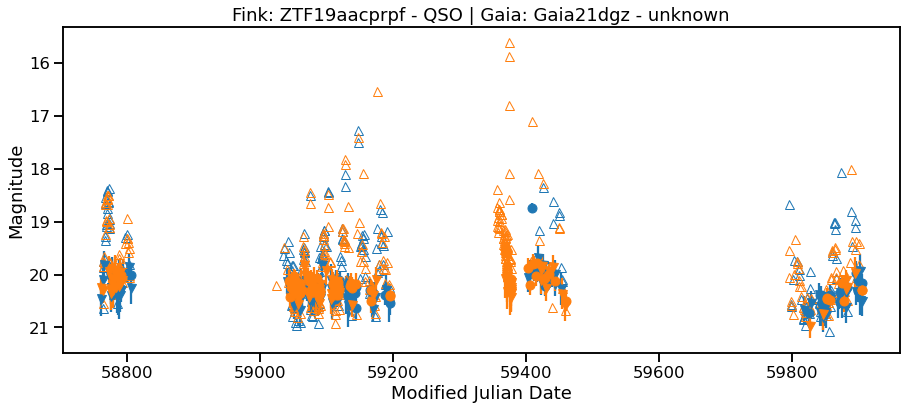

In [15]:
fink_oids = gaia[~f1 & f2]['i:objectId'].values
gaia_names = gaia[~f1 & f2]['Name'].values
gaia_classes = gaia[~f1 & f2]['Class'].values

NOBJECT = 10
for index, oid in enumerate(fink_oids[0:NOBJECT]):
    r = requests.post(
      'https://fink-portal.org/api/v1/objects',
      json={
        'objectId': oid,
        'withupperlim': 'True'
      }
    )

    # Format output in a DataFrame
    phot = pd.read_json(io.BytesIO(r.content))
    plot_photometry(phot, gaia_names[index], gaia_classes[index])

Display the ZTF photometry for 10 first QSO found in Gaia but without classification in Fink:

https://fink-portal.org/ZTF19adgdynw


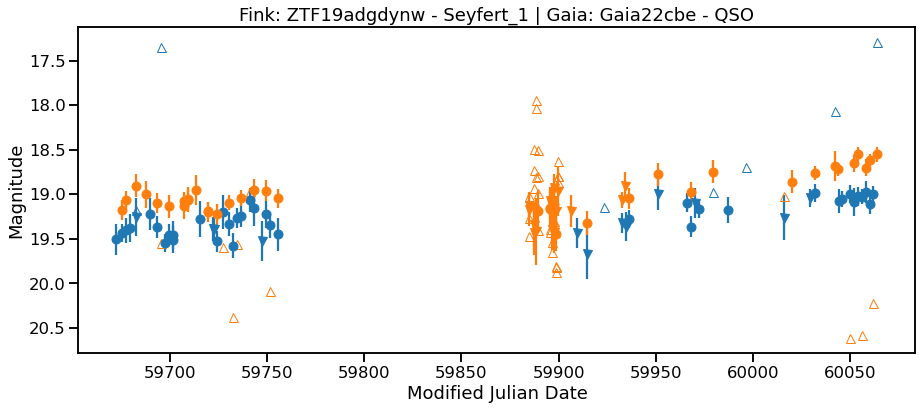

https://fink-portal.org/ZTF19aagtnvz


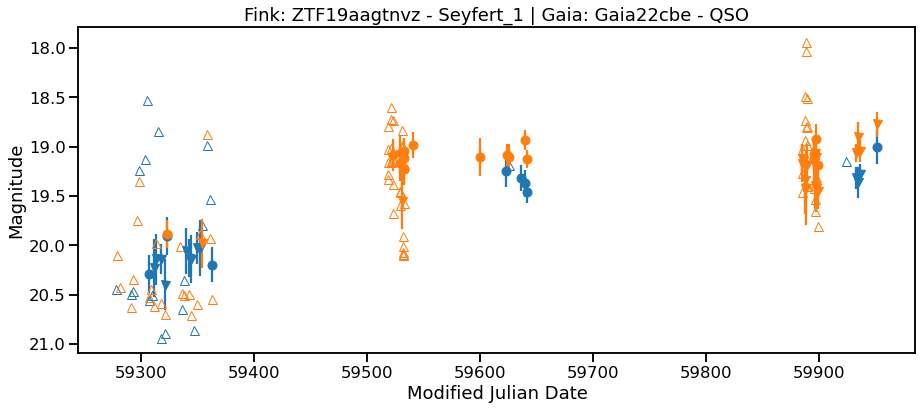

https://fink-portal.org/ZTF21aautzfa


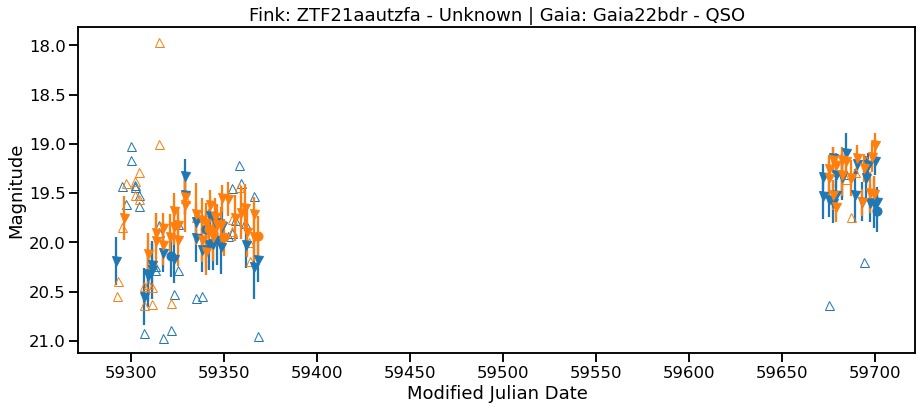

https://fink-portal.org/ZTF18abttmvx


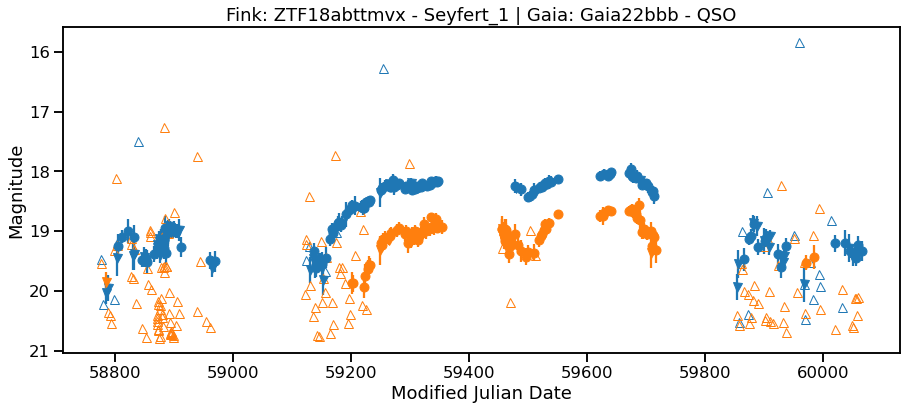

https://fink-portal.org/ZTF20ablwecm


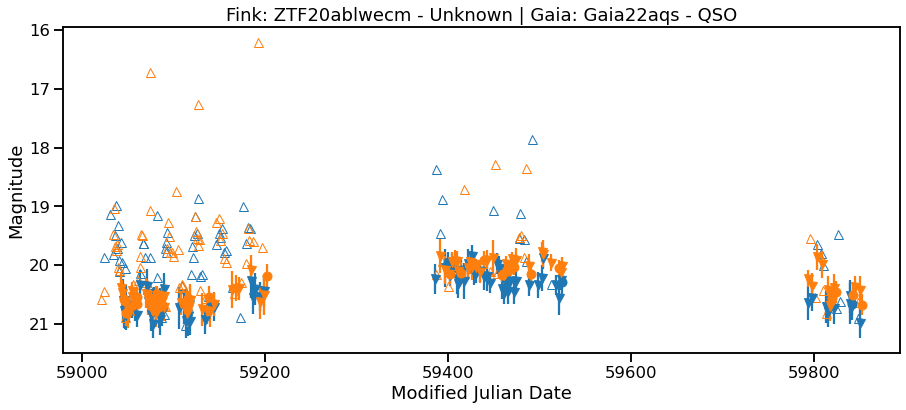

https://fink-portal.org/ZTF19abrmnwy


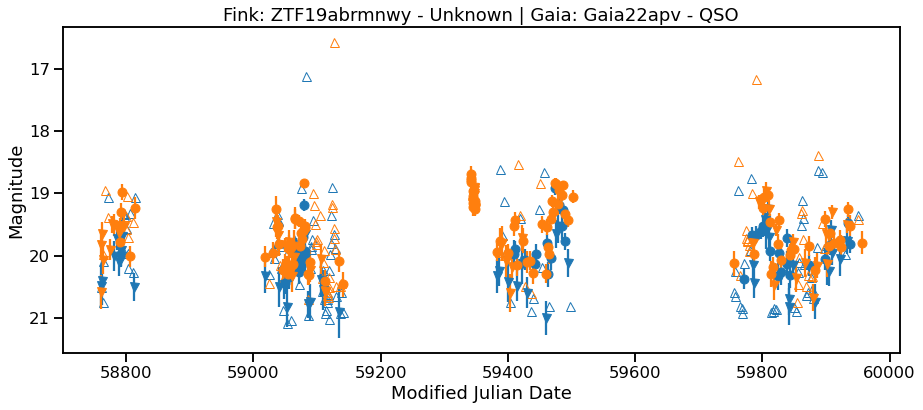

https://fink-portal.org/ZTF18aajjafl


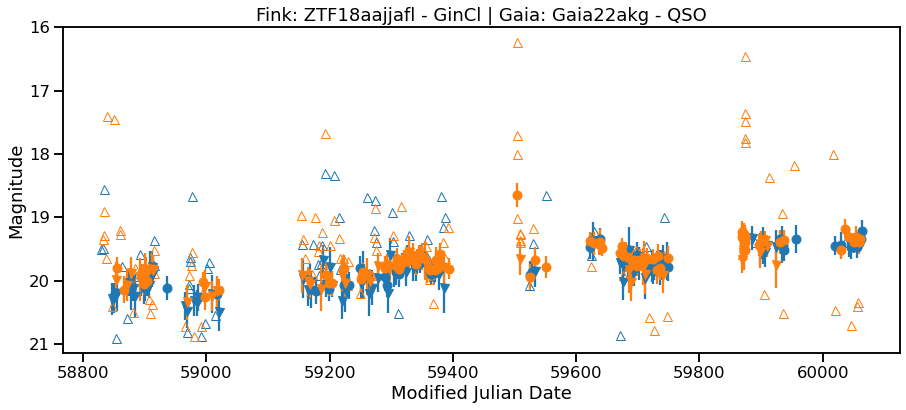

https://fink-portal.org/ZTF21ackapqj


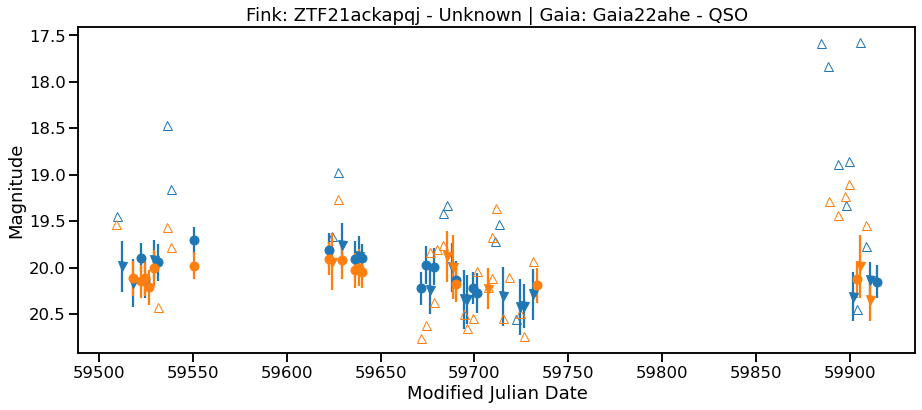

https://fink-portal.org/ZTF22aaeagso


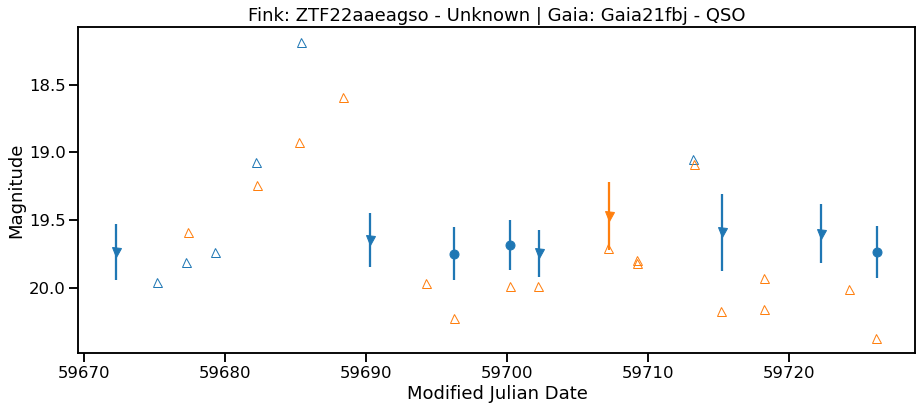

https://fink-portal.org/ZTF18aavtkta


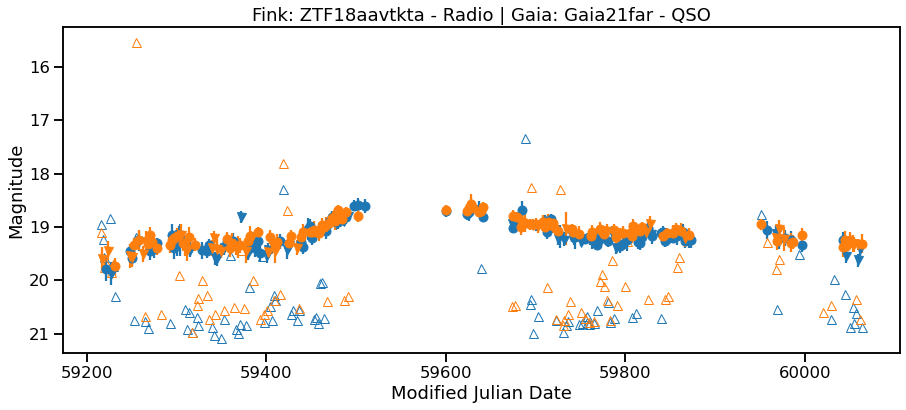

In [16]:
fink_oids = gaia[f1 & ~f2]['i:objectId'].values
gaia_names = gaia[f1 & ~f2]['Name'].values
gaia_classes = gaia[f1 & ~f2]['Class'].values

NOBJECT = 10
for index, oid in enumerate(fink_oids[0:NOBJECT]):
    r = requests.post(
      'https://fink-portal.org/api/v1/objects',
      json={
        'objectId': oid,
        'withupperlim': 'True'
      }
    )

    # Format output in a DataFrame
    phot = pd.read_json(io.BytesIO(r.content))
    plot_photometry(phot, gaia_names[index], gaia_classes[index])

## Full list of QSO both in Fink & Gaia

In [17]:
# You can sort by date -- most recent first -- by number of alerts
gaia_sorted = gaia.sort_values('i:jdstarthist', ascending=False)
# gaia_sorted = gaia.sort_values('i:ndethist', ascending=False)

fink_oids = gaia_sorted[f1 & f2]['i:objectId'].values
gaia_names = gaia_sorted[f1 & f2]['Name'].values
nmeasurements = gaia_sorted[f1 & f2]['i:ndethist'].values

for fink_oid, gaia_name, nmeasurement in zip(fink_oids, gaia_names, nmeasurements):
    url = 'https://fink-portal.org/{}'.format(fink_oid)
    print('Gaia: {}, Fink: {} ({} alerts)'.format(gaia_name, url, nmeasurement))

Gaia: Gaia22bva, Fink: https://fink-portal.org/ZTF22aaeuofv (4 alerts)
Gaia: Gaia21eyw, Fink: https://fink-portal.org/ZTF22aadmdjx (6 alerts)
Gaia: Gaia21fau, Fink: https://fink-portal.org/ZTF21ackaxrr (45 alerts)
Gaia: Gaia22apx, Fink: https://fink-portal.org/ZTF22aaaovhz (109 alerts)
Gaia: Gaia20aqm, Fink: https://fink-portal.org/ZTF21abrdwpe (38 alerts)
Gaia: Gaia21dsl, Fink: https://fink-portal.org/ZTF21abinayu (57 alerts)
Gaia: Gaia21dla, Fink: https://fink-portal.org/ZTF21abhrqok (113 alerts)
Gaia: Gaia21erq, Fink: https://fink-portal.org/ZTF21abcwohe (216 alerts)
Gaia: Gaia22aob, Fink: https://fink-portal.org/ZTF21abasnzf (41 alerts)
Gaia: Gaia22aer, Fink: https://fink-portal.org/ZTF21acdowtu (163 alerts)
Gaia: Gaia22bce, Fink: https://fink-portal.org/ZTF21achakpu (171 alerts)
Gaia: Gaia21bzm, Fink: https://fink-portal.org/ZTF21abfxhlg (16 alerts)
Gaia: Gaia16anm, Fink: https://fink-portal.org/ZTF21aavckgu (24 alerts)
Gaia: Gaia21dvd, Fink: https://fink-portal.org/ZTF21aawefnq (

/tmp/ipykernel_593727/3305094750.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fink_oids = gaia_sorted[f1 & f2]['i:objectId'].values
/tmp/ipykernel_593727/3305094750.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gaia_names = gaia_sorted[f1 & f2]['Name'].values
/tmp/ipykernel_593727/3305094750.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nmeasurements = gaia_sorted[f1 & f2]['i:ndethist'].values
